# Data Wrangling

## Setup

In [1]:
# Necessary imports and more
# ==========================

import sys
sys.path.append('..')
import src
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
from pathlib import Path

## Data load

In [16]:
# Raw data load
# =============

raw_data_file = '../data/raw/hipparcos-voidmain.csv'
raw_data = pd.read_csv(raw_data_file)

missing_values_file = '../data/interim/missing_values.csv'
missing_values = pd.read_csv(missing_values_file, index_col = [0])

## Manual feature filtering
Given the nature of the features present in the project's raw data, a number columns or features will be manually dropped, with each having a brief explanation beforehand. However, links to the available documentation from the European Space Agency (ESA) are provided in the project's `README.md` file, should further details be required.

In [20]:
# Empty list to store names of features to drop
# =============================================

features_to_drop = []

In [19]:
# Splitting dataframe of missing values by percentages (>= and < 50%)
# ===================================================================

missing_50pc_or_more = missing_values[missing_values['Percent missing'] >= 50]
print('Features missing 50% or more values: \n',missing_50pc_or_more.index, '\n')

missing_less_than_50pc = missing_values[missing_values['Percent missing'] < 50]
print('Features missing less than 50% values: \n',missing_less_than_50pc.index)

Features missing 50% or more values: 
 Index(['Period', 'Source', 'morePhoto', 'Notes', 'moreVar', 'CombMag', 'Proxy',
       'm_HIP', 'e_rho', 'theta', 'rho', 'e_dHp', 'dHp', 'VarFlag', 'Chart',
       'm_BTmag', 'm_Hpmag', 'AstroRef', 'MultFlag', 'Nsys', 'n_CCDM', 'CCDM',
       'Qual', 'CoD', 'CPD', 'Survey'],
      dtype='object') 

Features missing less than 50% values: 
 Index(['HvarType', 'BD', 'HD', 'BTmag', 'e_BTmag', 'VTmag', 'e_VTmag',
       'SpType', 'r_SpType', 'F2', 'e_B-V', 'r_B-V', 'B-V', 'V-I', 'e_V-I',
       'Hpscat', 'o_Hpmag', 'Hpmax', 'HPmin', 'e_RAdeg', 'DE:RA', 'e_pmDE',
       'e_pmRA', 'e_Plx', 'e_DEdeg', 'pmDE', 'Plx:DE', 'pmRA', 'Plx', 'DEdeg',
       'RAdeg', 'Plx:RA', 'Ncomp', 'pmRA:DE', 'pmRA:Plx', 'pmDE:RA', 'pmDE:DE',
       'pmDE:Plx', 'pmDE:pmRA', 'F1', 'pmRA:RA', 'e_Hpmag', 'Hpmag', 'r_Vmag',
       'Vmag', 'DEdms', 'RAhms', '(V-I)red', 'HIP', 'r_V-I', '---', 'Catalog'],
      dtype='object')


In [21]:
# All features missing 50% or more values are stored in list to drop
# due to the sheer amount of missing data
# ==================================================================

for col in list(missing_50pc_or_more.index):
  features_to_drop.append(str(col))

In [22]:
# Out of the features with less than 50% missing data, those beginning with 'e_' represent standard errors 
# of different observed measurements. These errors were included in the Catalogue but have 
# already been used in calculations that resulted in other features' values.
# As such, they do not represent useful data and are also stored in the list of features to drop.
# ========================================================================================================

for col in list(missing_less_than_50pc.index):
  if 'e_' in str(col):
    features_to_drop.append(str(col))

In [24]:
# Features (RAhms, DEdms) and (RAdeg, DEdeg) represent the same data, the star's
# right ascension (RA) and declination (DE), which are its astronomical "coordinates",
# so one pair can be dropped as well
# ====================================================================================

features_to_drop.append('RAhms')
features_to_drop.append('DEdms')

In [25]:
# Feature 'Catalog' indicates whether a star is included in the Hipparcos or Tycho Catalogue,
# and contains only one value (H) as seen in the EDA, so it will be dropped as well
# ==========================================================================================

features_to_drop.append('Catalog')

In [26]:
# Features 'HIP', 'HD' and 'BD' are described as identifiers, so they will be dropped
# ===================================================================================

features_to_drop.append('HIP')
features_to_drop.append('HD')
features_to_drop.append('BD')

In [27]:
# Feature 'r_Vmag' is a flag that indicates where the V magnitude (feature 'Vmag') has
# been derived from. As merely a flag, it is therefore not significant and will be dropped.
# =========================================================================================

features_to_drop.append('r_Vmag')

In [28]:
# Features 'RAdeg', 'DEdeg', 'Plx', 'pmRA' and 'pmDE' are observations of stars' positions,
# angular displacements, and motions. These observations in themselves do not contribute significant
# information, whereas the correlation coefficients between (such as 'DE:RA', 'pmRA:Plx') them do.
# As such, only the correlation coefficients will be preserved for further analysis.
# ===================================================================================================

features_to_drop.append('RAdeg')
features_to_drop.append('DEdeg')
features_to_drop.append('Plx')
features_to_drop.append('pmRA')
features_to_drop.append('pmDE')

In [30]:
# Feature 'F1' represents percentage of rejected data in order to obtain an acceptable
# astrometric solution for a given star. It is not, then, data pertaining to the star
# itself, and will therefore be dropped.
# ====================================================================================

features_to_drop.append('F1')

In [31]:
# Feature 'F2' represents a statistic called "goodness-of-fit" of the astrometric solution
# to the accepted pre-existing data. It is not, then, data pertaining to a star itself
# either, and will therefore be dropped too.
# ========================================================================================

features_to_drop.append('F2')

In [32]:
# Feature '---' is a duplicate of feature 'HIP', an identifier previously dropped.
# It will therefore be dropped as well.
# ================================================================================

features_to_drop.append('---')

In [33]:
# Feature 'r_B-V' is a flag that indicates the source for feature 'B-V'.
# As such, it is not significant and will be dropped.
# ======================================================================

features_to_drop.append('r_B-V')

In [34]:
# Feature 'r_V-I' is a flag that indicates the method adopted to estimate
# the value of feature 'V-I'. As such, it is not significant and will be dropped.
# ===============================================================================

features_to_drop.append('r_V-I')

In [35]:
# Feature 'HvarType' is a flag that indicates the origin of extra scatter in
# photometric data, feature 'Hpscat'. As such, it is not significant and will be dropped.
# =======================================================================================

features_to_drop.append('HvarType')

In [36]:
# Feature 'o_Hpmag' represents the number of photometric observations used for the
# construction of the median (feature 'Hpmag'), standard error (feature 'e_Hpmag')
# and scatter (feature 'Hpscat') of the stars' measurements. As such, it is not
# significant and will be dropped.
# ================================================================================

features_to_drop.append('o_Hpmag')

In [37]:
# Feature 'r_SpType' is a flag that indicates the source of the spectral type of a star.
# As such, it is not significant and will be dropped.
# ======================================================================================

features_to_drop.append('r_SpType')

In [38]:
# Final amount of features to be dropped
# =======================================

print('Amount of features to be dropped thus far: ',len(features_to_drop))

Amount of features to be dropped thus far:  56


In [39]:
# Drop features and store result in a new dataframe
# =================================================

working_data = raw_data.drop(columns = features_to_drop).copy()

In [44]:
# Check new dataframe shape
# =========================

working_data.shape

(118218, 22)

In [43]:
# Calculate new dataframe amount of missing values
# ================================================
working_data_missing_values = src.check_missing(working_data)

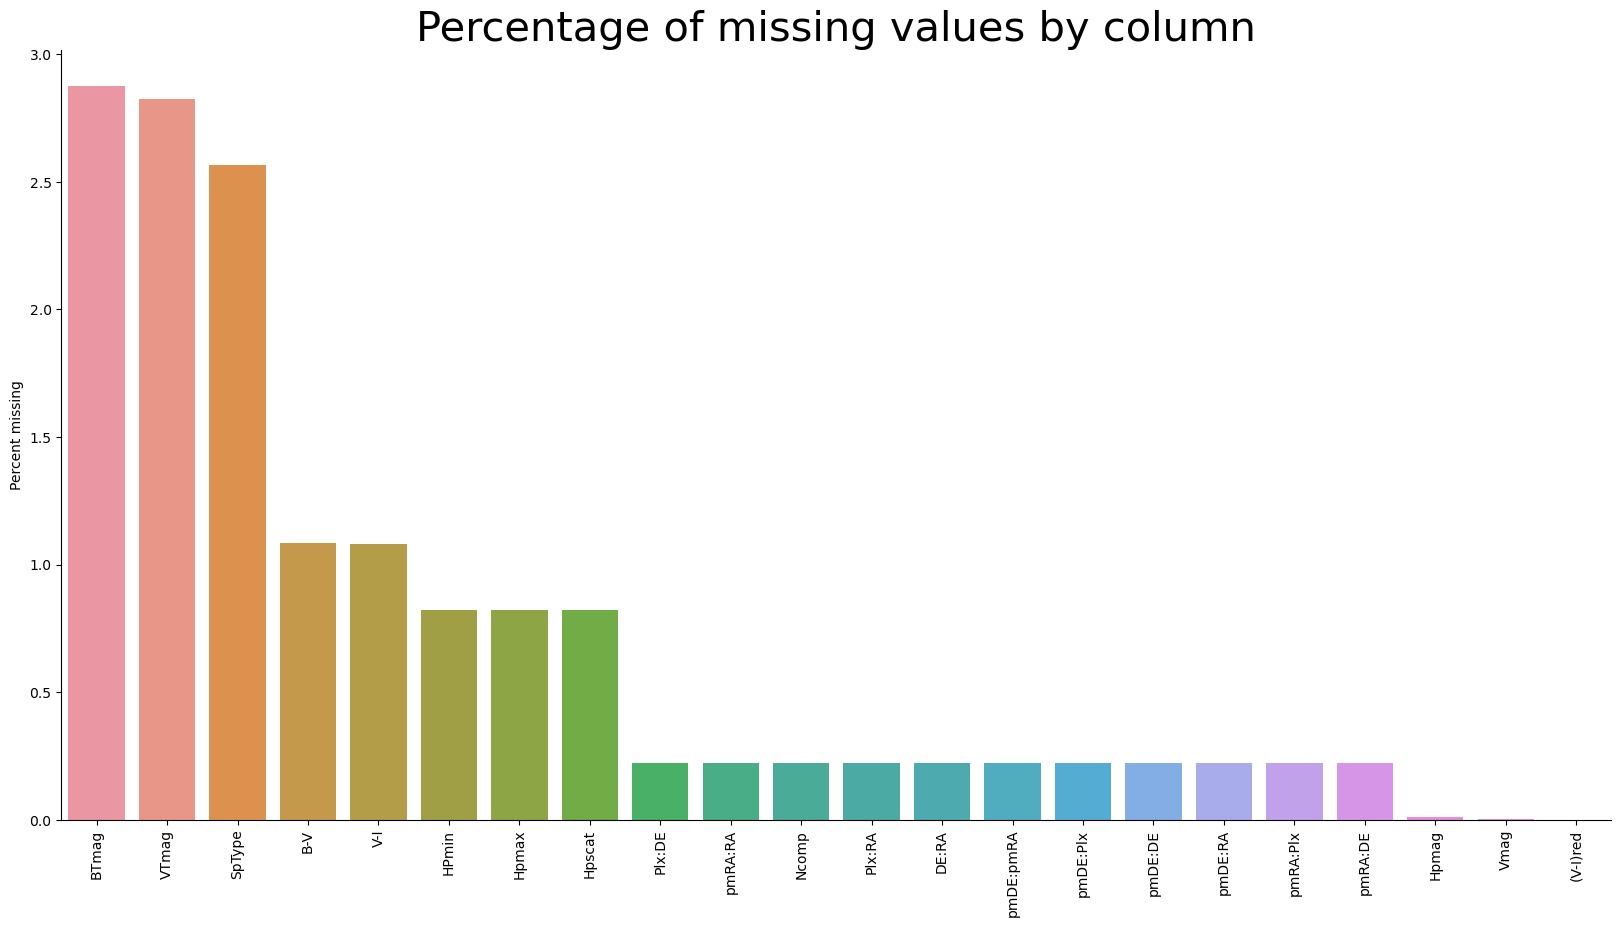

In [45]:
# Graph new dataframe missing values data
# =======================================

fig, ax = plt.subplots(figsize = (20, 10))
sns.despine(fig)
graph = sns.barplot(data = working_data_missing_values, x = working_data_missing_values.index, y = 'Percent missing')
plt.title('Percentage of missing values by column', fontsize = 30)
plt.xticks(rotation = 90)
plt.show()

In [46]:
# Remove rows with remaining missing data
# =======================================

working_data = working_data.dropna(axis = 0)
working_data.shape

(112312, 22)

In [47]:
# Working data overview
# =====================

working_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Vmag,112312.0,8.258498,1.202059,-0.6200,7.6000,8.3800,9.0400,12.0600
DE:RA,112312.0,0.002414,0.210415,-0.9800,-0.1400,0.0000,0.1400,0.9300
Plx:RA,112312.0,0.003329,0.202032,-0.8300,-0.1300,0.0000,0.1400,0.9300
Plx:DE,112312.0,-0.087203,0.155634,-0.7800,-0.1900,-0.0900,0.0200,0.8000
pmRA:RA,112312.0,0.010221,0.209070,-0.9900,-0.1200,0.0200,0.1500,0.8800
pmRA:DE,112312.0,-0.000845,0.157782,-0.9500,-0.0900,0.0000,0.0900,0.8600
pmRA:Plx,112312.0,0.003067,0.159311,-0.7300,-0.1000,0.0000,0.1000,0.7200
pmDE:RA,112312.0,-0.000928,0.148788,-0.9400,-0.0900,0.0000,0.0900,0.9700
pmDE:DE,112312.0,-0.022056,0.263675,-0.9700,-0.2000,-0.0300,0.1400,0.9400
pmDE:Plx,112312.0,0.030544,0.161886,-0.8100,-0.0800,0.0300,0.1300,0.7500


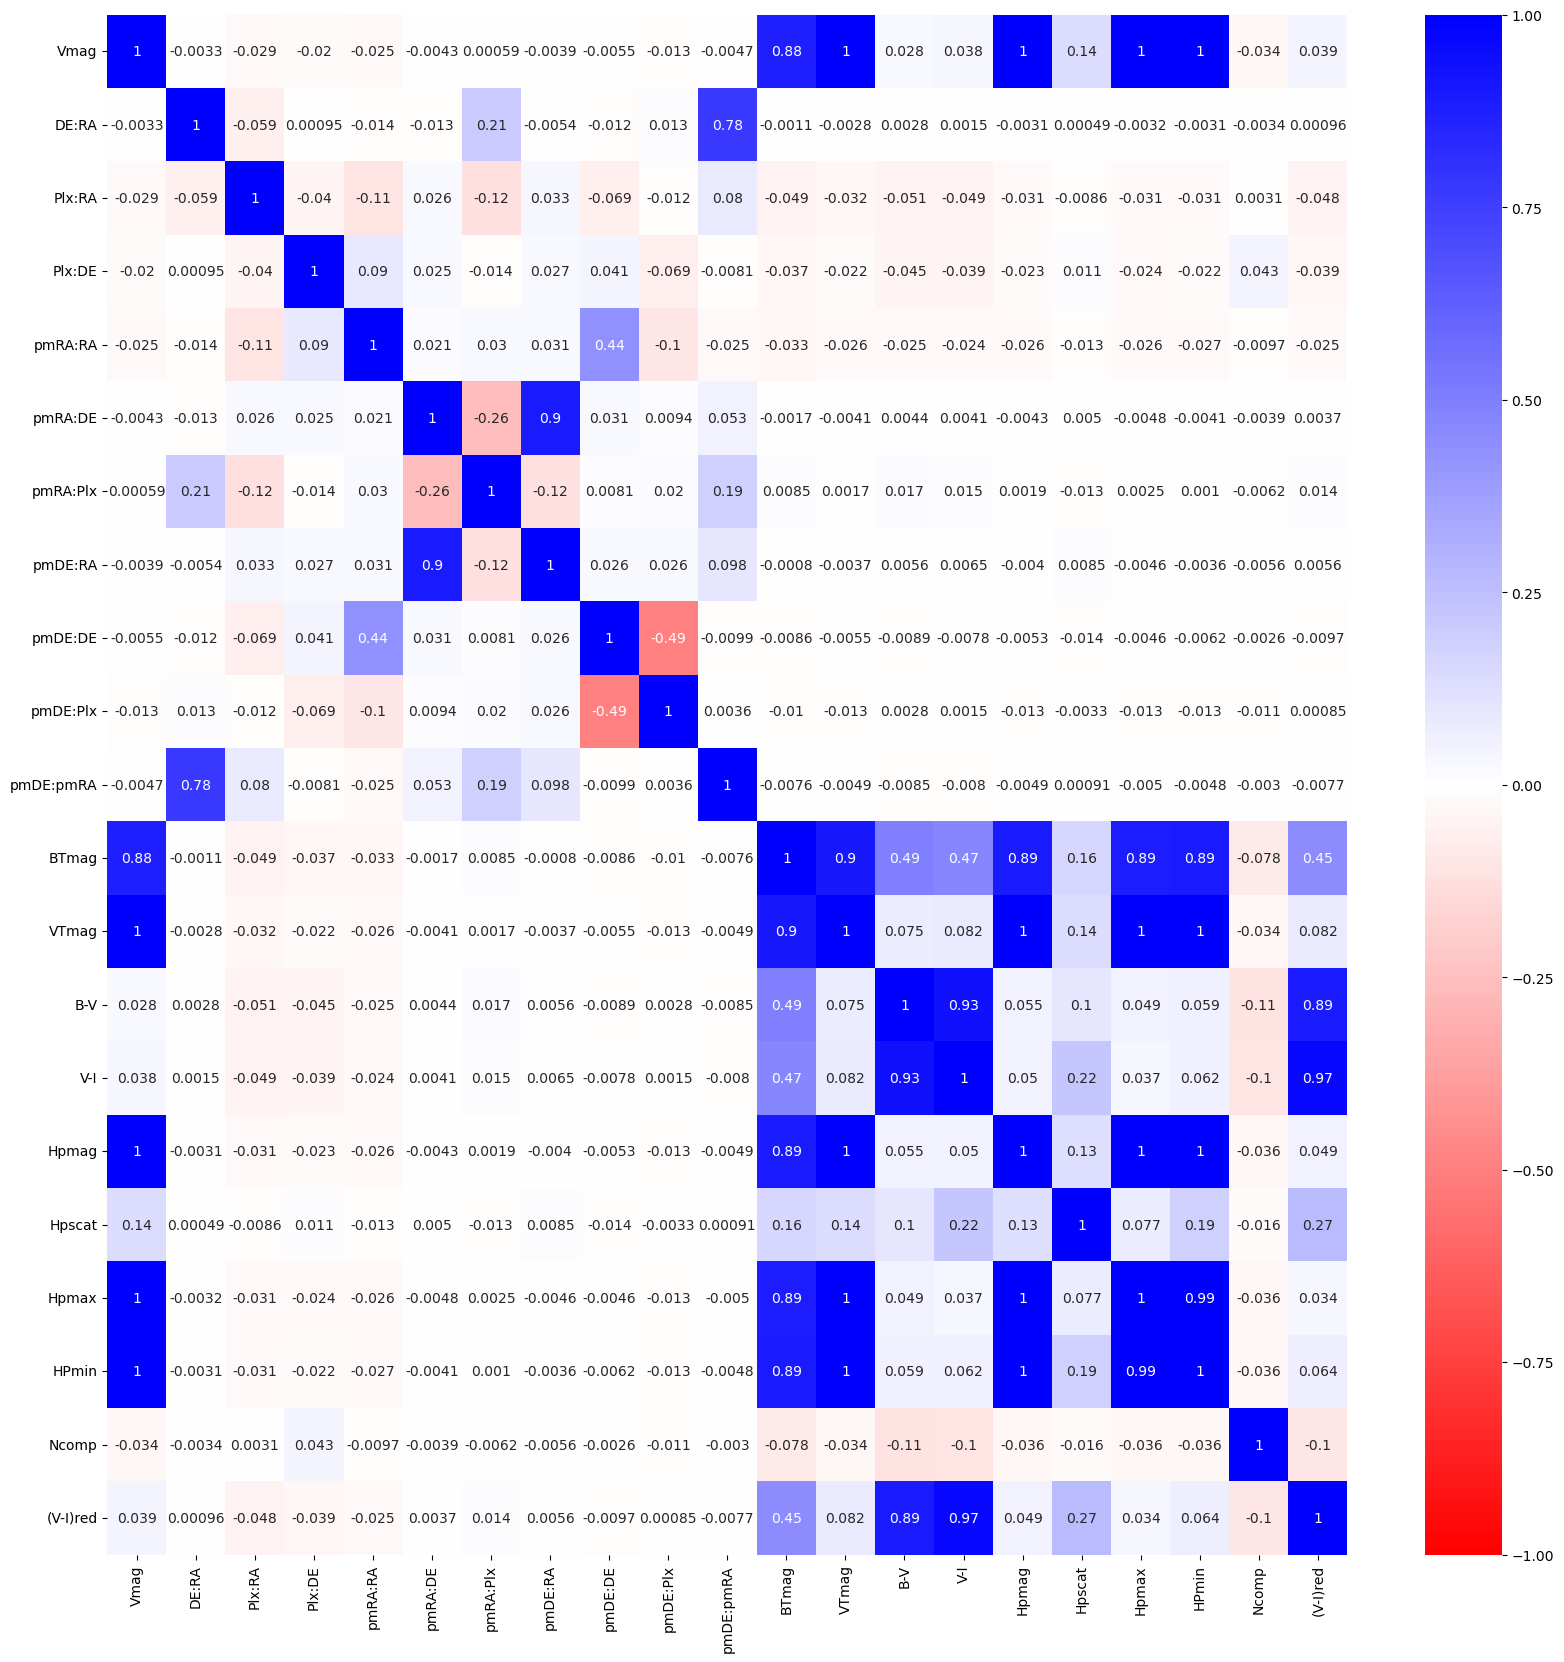

In [48]:
# Visualize working data features correlations
# ============================================

plt.figure(figsize = (20, 20))
sns.heatmap(working_data.corr(), annot = True, vmin = -1, vmax =1, cmap = 'bwr_r')
plt.show()

## Target variable adjustment
At this point, the target variable needs to be defined. This will be the `SpType` column, which represents a star's **_spectral type_**. First, let's take a look at the unaltered column.

In [50]:
# Store the target column's value counts into a new dataframe and describe
# ========================================================================

target_groups = working_data['SpType'].value_counts().rename_axis('Class').reset_index(name  = 'Count')
target_groups.describe()

,Count
count,3956.000000
mean,28.390293
std,258.876243
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,8490.000000


As can be seen, the spectral type (or _class_) with the most elements in it has just under 8 500 elements, but at the same time, the mean for the spectral types value counts is only 28.3 which, along with the quartiles shown, indicates that the majority of the classes have only between 1 and 3 elements.
Let's take a look, for example, at how many classes have 10 or less elements in them.

In [78]:
# How many classes have 10 or less elements in them?
# ==================================================

ten_or_less_elements = len(target_groups[target_groups['Count'] <= 10])
print('{} classes have 10 or less elements, or {:.2f}% of all classes'.format(ten_or_less_elements, (ten_or_less_elements * 100)/len(target_groups)))

3438 classes have 10 or less elements, or 86.91% of all classes


This is because although a star's spectral type is _mostly_ comprised of its temperature class and sub-type (which are represented by a single character each), the Hipparcos Catalogue's spectral type data contains more bits of information. However, these other bits of information are obtained from sources other than the Hipparcos Mission and are tied to features that have been dropped due to their amount of missing data or due to being marked as "flags" in the documentation, etc.

As such, all of the spectral types will be reduced to their "base" form (temperature class and sub-type) to maintain a degree of simplicity. Note that with this step each data point will remain representative of reality, albeit a simplified version of it.

In [79]:
# New list object for base spectral types
# =======================================

base_types = []

In [80]:
# Iterate over SpType column and get base spectral type of each element
# =====================================================================

for element in working_data['SpType']:
  base_types.append(src.get_base_spectral_type(element))

In [92]:
# Create new column in working dataframe for base spectral type
# =============================================================

working_data = working_data.assign(BaseSpType = base_types)

In [93]:
# Drop old spectral type column and store in new dataframe
# ========================================================

adjusted_data = working_data.drop(columns = 'SpType').copy()

(112312, 22)

## Feature selection

In [95]:
# Required imports for SelectKBest feature selection
# ==================================================

from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest


# Splitting data into independent (X) and target (y) features
# ===========================================================

y = adjusted_data.BaseSpType
X = adjusted_data.drop(columns = ['BaseSpType']).copy()


# Print starting X-dataframe shape for later comparison
# =====================================================
print('Starting X shape: ', X.shape)


# Feature selector creation
# =========================

feature_selector = SelectKBest(k = 'all')
fit = feature_selector.fit(X, y)


# P-values and scores for each feature fit
# ========================================

p_values = pd.DataFrame(fit.pvalues_)
scores = pd.DataFrame(fit.scores_)


# Summary stats for all input features
# ====================================

input_features = pd.DataFrame(X.columns)
summary_stats = pd.concat([input_features, p_values, scores], axis = 1)
summary_stats.columns = ['Input features', 'p_value', 'score']
summary_stats.sort_values(by = 'p_value', inplace = True)


# Statistical significance thresholds
# ===================================

p_value_threshold = 0.05
score_threshold = 5


# Select variables based on defined thresholds
# ============================================

selected_variables = summary_stats.loc[(summary_stats['score'] >= score_threshold) &
                                       (summary_stats['p_value'] <= p_value_threshold)]
selected_variables = selected_variables['Input features'].tolist()
X_new = X[selected_variables]


# Print new X-dataframe shape for comparison
# ==========================================
print('New X shape: ', X_new.shape)

Starting X shape:  (112312, 21)
New X shape:  (112312, 14)


In [96]:
# Re-assign dataframes for ease of use
# ====================================

features, target = X_new, y

In [97]:
# Features overview
# =================

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Vmag,112312.0,8.258498,1.202059,-0.6200,7.6000,8.3800,9.0400,12.0600
HPmin,112312.0,8.401006,1.225764,-0.4800,7.7300,8.5300,9.2000,13.3200
Hpmax,112312.0,8.328078,1.201799,-0.6000,7.6700,8.4600,9.1200,11.9600
Hpscat,112312.0,0.021349,0.051797,0.0030,0.0110,0.0160,0.0210,1.9760
Hpmag,112312.0,8.362668,1.212061,-0.5536,7.7008,8.4926,9.1563,12.0918
V-I,112312.0,0.746971,0.548205,-0.4200,0.3900,0.6700,1.0400,6.1300
B-V,112312.0,0.695917,0.486372,-0.4000,0.3370,0.6000,1.0680,5.4600
VTmag,112312.0,8.336103,1.201766,-0.6080,7.6800,8.4650,9.1220,12.0580
BTmag,112312.0,9.134189,1.370588,-0.4170,8.3400,9.2670,10.0870,14.1140
(V-I)red,112312.0,0.742507,0.568444,-0.5200,0.3900,0.6700,1.0300,9.2900


In [98]:
# Features skewness
# =================

features.skew()

Vmag        -0.756979
HPmin       -0.729225
Hpmax       -0.794558
Hpscat      21.732139
Hpmag       -0.769402
V-I          1.350127
B-V          0.378005
VTmag       -0.772087
BTmag       -0.692104
(V-I)red     1.873019
Plx:RA       0.107622
Ncomp        2.866495
Plx:DE      -0.087546
pmRA:Plx     0.060438
dtype: float64

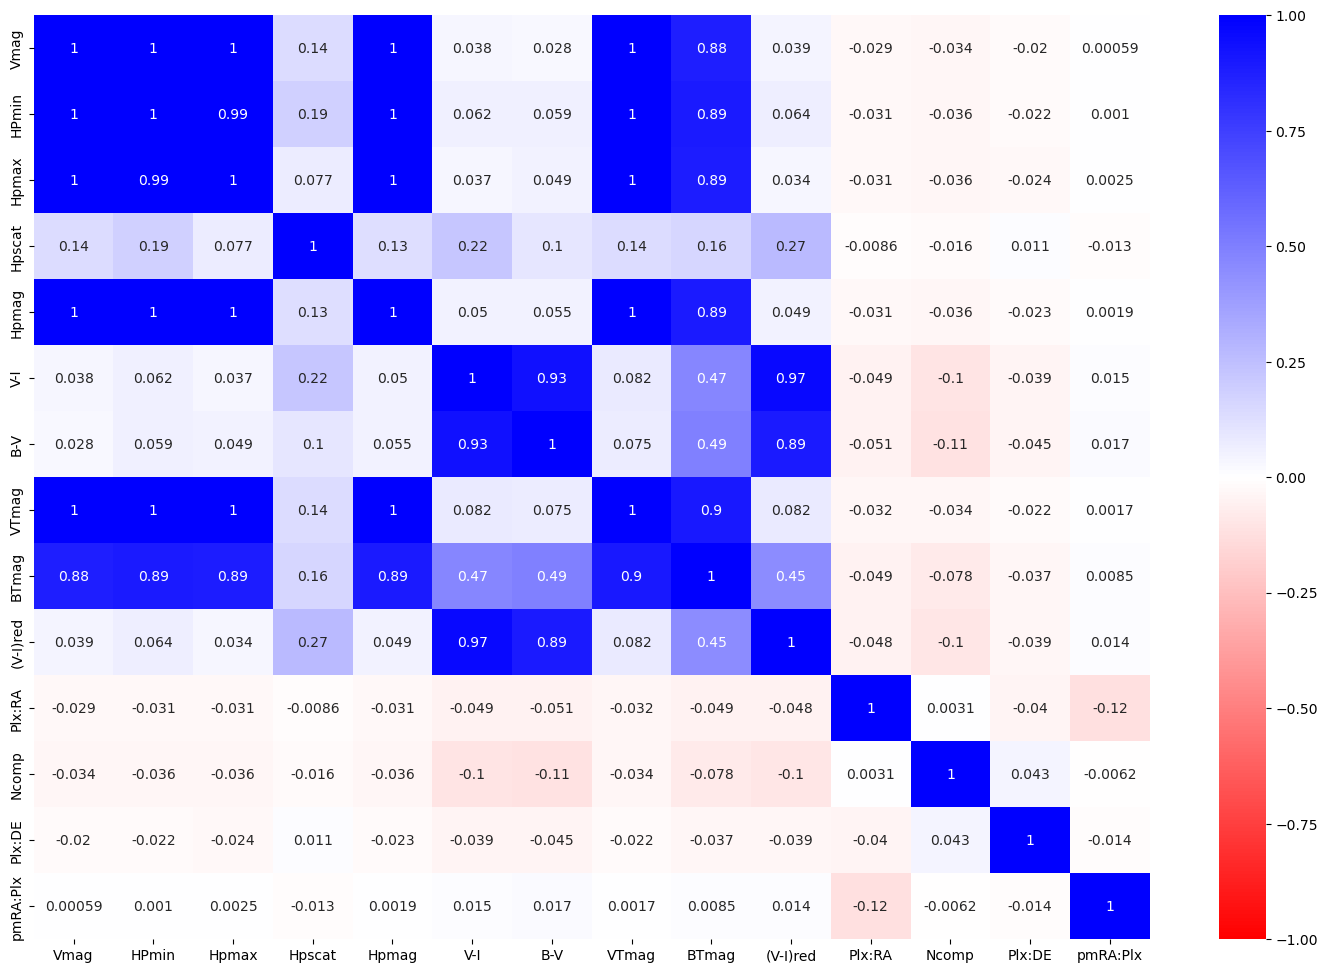

In [99]:
# Correlations
# ============

plt.figure(figsize = (18, 12))
sns.heatmap(features.corr(), cmap = 'bwr_r', annot = True, vmin = -1, vmax = 1)
plt.show()

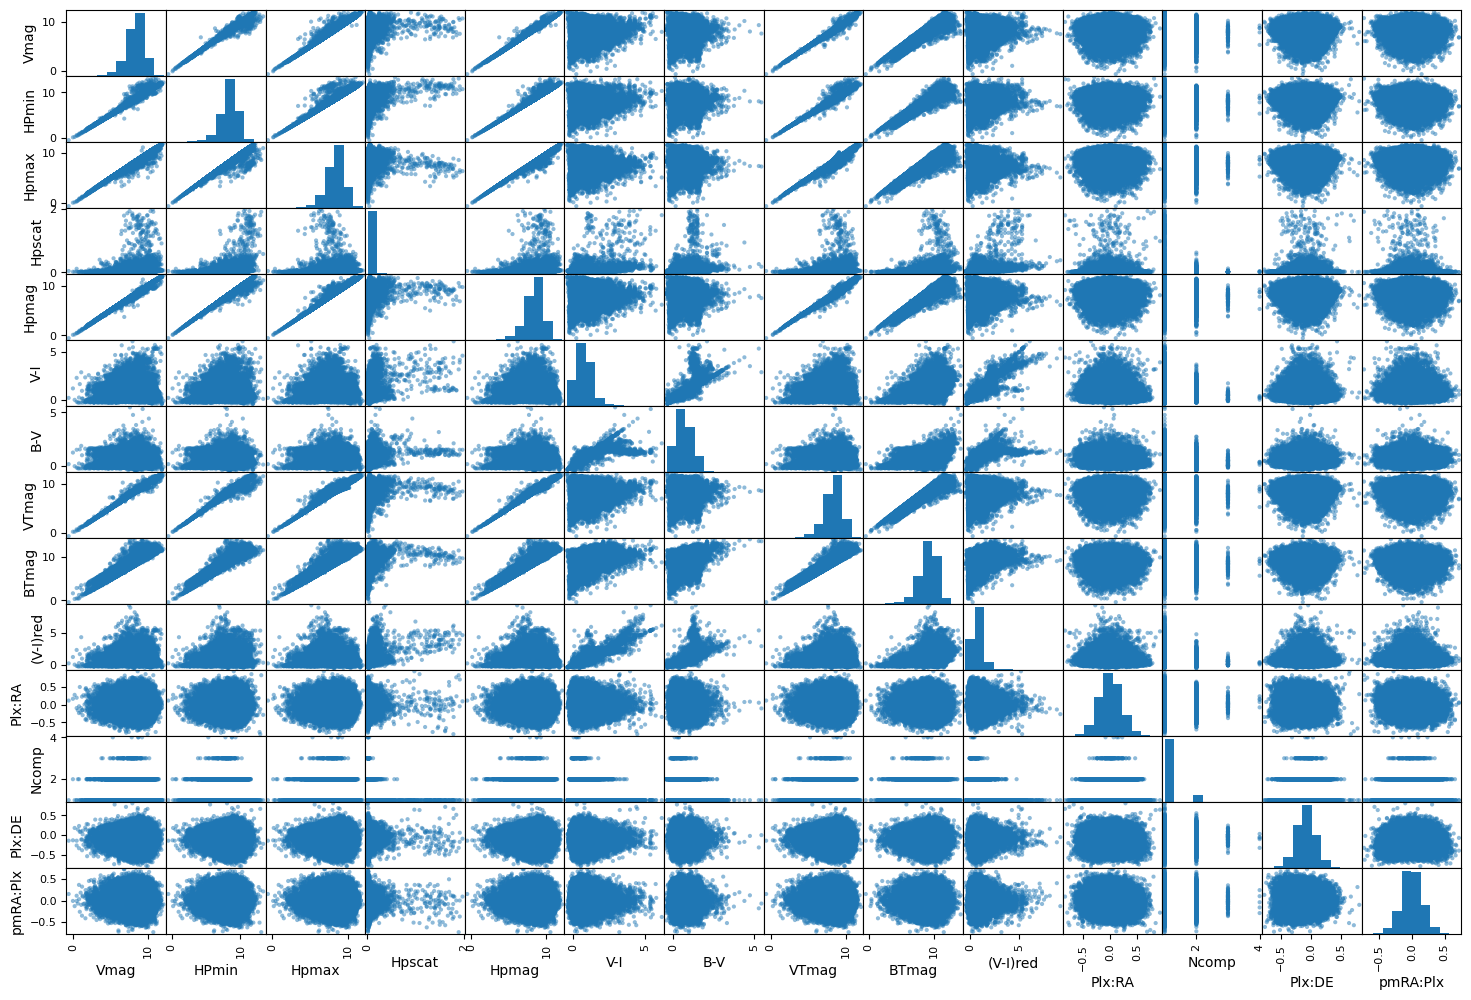

In [100]:
# Scatter matrix overview
# =======================

from pandas.plotting import scatter_matrix

scatter_matrix(features, figsize = (18,12))
plt.show()

In [101]:
# Stored final processed data in new dataframe
# ============================================

processed_data = pd.concat([features, target], axis = 1)
processed_data.head()

,Vmag,HPmin,Hpmax,Hpscat,Hpmag,V-I,B-V,VTmag,BTmag,(V-I)red,Plx:RA,Ncomp,Plx:DE,pmRA:Plx,BaseSpType
0,9.10,9.24,9.17,0.017,9.2043,0.55,0.482,9.130,9.643,0.66,-0.07,1.0,-0.11,-0.01,F5
1,9.27,9.44,9.37,0.015,9.4017,1.04,0.999,9.378,10.519,1.04,-0.14,1.0,-0.24,0.21,K3
2,6.61,6.62,6.60,0.008,6.6081,0.00,-0.019,6.621,6.576,0.00,0.09,1.0,0.04,-0.06,B9
3,8.06,8.18,8.12,0.015,8.1498,0.43,0.370,8.092,8.471,0.43,-0.09,1.0,-0.03,0.08,F0
4,8.55,8.74,8.68,0.019,8.7077,0.90,0.902,8.656,9.693,0.95,0.24,1.0,0.06,0.20,G8


In [102]:
# Save to CSV file
# ================

filepath = Path('../data/processed/processed_data.csv')
processed_data.to_csv(filepath)